In [1]:
import sys;
sys.path.insert(0, '..')

In [2]:
from math import pi, cos, sin, sqrt, atan2, tan
from util import is_close, all_close, cis, print_state_table
from sim_circuit import *

## Exercise 1

The circuit to encode a geometric sequence state in listing 8.1 adds a Hadamard gate to each qubits, and then a phase gate to each qubit.
The following function creates the same circuit in a different order:

In [3]:
def geometric_sequence_circuit_single_loop(n, theta):

    N = 2**n

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])
        qc.p(2 ** j * theta, q[j])

    return qc

Create a geometric sequence state using the function above and then check that the amplitudes of the state match the expected values.

**Answer:**

In [4]:
n = 3
theta = pi/3
qc = geometric_sequence_circuit_single_loop(n, theta)
assert all_close(qc.run(), [1/sqrt(2**n)*cis(k*theta) for k in range(2**n)])

## Exercise 2

Justify that using the circuit in listing 6.2 to encode a frequency $0 \le v < 2$ in a single-qubit state is the same as the phase-to-magnitude method we saw in chapter 5.
The phase is $\theta = v\pi$.

**Answer:**

In [5]:
def encode_frequency(n, v):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])

    for j in range(n):
        qc.p(2 * pi / 2 ** (n - j) * v, q[j])

    qc.report('geometric_sequence')

    qc.iqft(range(n))

    qc.report('iqft')

    return qc

In [6]:
def phase_to_mag_1q(v):
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    
    theta = v*pi
    qc.h(q[0])
    qc.p(theta, q[0])
    qc.h(q[0])

    return qc

In [7]:
n = 1
v = 1.2
assert all_close(encode_frequency(n, v).run(), phase_to_mag_1q(v).run())

## Exercise 3

Write code that uses random states to verify the following alternative expression for the amplitudes of a periodic n-qubit quantum state, with $N = 2^n$.

|Outcome |Amplitude |
| :----: | :------: |
|k       |$$\text{cis} \left((N - 1)(v - k) \frac{\pi}{N} \right) \frac{2}{N} \sum_{m = 0}^{N/2} \cos \left((2m + 1)(v - k) \frac{\pi}{N} \right)$$ |

**Answer:**

In [8]:
def complex_sincd_sum(n, v):
    N = 2**n
    return [2/N*sum(cos((2*m+1)*(v-k)*pi/N) for m in range(N//2))*cis((N-1) * (v-k)*pi/N) for k in range(N)]

In [9]:
n = 3

# generate pseudo-random between 0 and 2**n
import random
v = random.randrange(2**n)

assert all_close(encode_frequency(n, v).run(), complex_sincd_sum(n, v))

## Exercise 4

Verify that the amplitudes of a phased discrete state can be expressed recursively as shown in the following tree for a three-qubit state:


**Answer:**

In [10]:
def recursive_complex_discrete_sinc(n, v):
    if n == 1:
        return [cis(v*pi/2)*cos(v*pi/2), -1j*cis(v*pi/2)*sin(v*pi/2)]
    
    a = recursive_complex_discrete_sinc(n-1, v)

    return ([a[k]*cis((v - k)*pi/2**n)*cos((v - k)*pi/2**n) for k in range(2**(n-1))] + [a[k]*cis((v - k)*pi/2**n)*-1j*sin((v - k)*pi/2**n) for k in range(2**(n-1))])

In [11]:
n = 3
v = 1.5
assert all_close(recursive_complex_discrete_sinc(n, v), complex_sincd_sum(n, v))

## Exercise 5

Let's look at an example of a quantum circuit that uses the QFT.
Let's initialize a three-qubit state and apply an $R_Y(-\frac{\pi}{2})$-gate to the first qubit:

In [12]:
n = 3
theta = -pi/2
q = QuantumRegister(n)
qc = QuantumCircuit(q)
qc.ry(theta, q[0])
qc.report('state')

([1, 0, 0, 0, 0, 0, 0, 0],
 [0.7071067811865476, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 1)

The resulting state can be expressed with the following list comprehension:

In [13]:
N = 8
s = [cos(k*pi/2 - theta/2) if k in [0, 1] else 0 for k in range(N)]
assert all_close(qc.reports['state'][2], s)

Now, let’s perform a QFT on all the qubits in the system:

In [14]:
qc.append_qft(q)
qc.report('qft')

([0.7071067811865476, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [2.7755575615628914e-17,
  (0.0732233047033631-0.1767766952966368j),
  (0.24999999999999992-0.24999999999999992j),
  (0.42677669529663675-0.17677669529663684j),
  (0.4999999999999999+0j),
  (0.42677669529663675+0.1767766952966368j),
  (0.24999999999999997+0.24999999999999992j),
  (0.07322330470336316+0.17677669529663684j)],
 8)

Find a list comprehension expression of the state after applying the QFT (like the one above) that will satisfy the following assert statement:


```
assert all_close(qc.reports['qft'][2], s)
```

**Answer:**

In [15]:
s = [1/sqrt(N)*cos(theta/2) + 1/sqrt(N)*sin(theta/2)*cis(k*2*pi/N) for k in range(N)]
assert all_close(qc.reports['qft'][2], s)

## Exercise 6

Verify that for a given integer $n$, the following circuit encodes a quantum state with the following properties:

1. The probability of the 0 outcome is $\frac{1}{2}$.

2. The probability of an odd outcome $ 0 < k < 2^n$ is $\frac{\sqrt{2}}{2^n}\frac{1}{\sin^2(k\frac{\pi}{2^n})}$.

3. The probability of the other outcomes, which are all even, is 0.

In [16]:
def one_over_sine(n):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for i in range(1, n):
        qc.h(i)

    qc.x(0)
    qc.append_iqft(q, reversed=True, swap=False)

    return qc

In [17]:
qc = one_over_sine(4)
state = qc.run()

In [18]:
print_state_table(state)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0000    0.7071 + i0.0000    0.7071        0.00°   ████████████████          0.5   
1        0001   -0.0884 + i0.4444    0.4531      101.25°   ██████████                0.2053
2        0010    0.0000 + i0.0000    0.0                                             0.0   
3        0011   -0.0884 + i0.1323    0.1591      123.75°   ███                       0.0253
4        0100    0.0000 + i0.0000    0.0                                             0.0   
5        0101   -0.0884 + i0.0591    0.1063      146.24°   ██                        0.0113
6        0110    0.0000 + i0.0000    0.0                                             0.0   
7        0111   -0.0884 + i0.0176    0.0901      168.74°   ██                        0.0081
8        1000    0.0000 + i0.0000    0.0                             

**Answer:**

In [19]:
n = 4
N = 2**n

qc = one_over_sine(n)
state = qc.run()

# amplitude of outcome 0 is 1/2
assert is_close(abs(state[0])**2, 1/2)

for k in range(1, N):
    # probability of odd outcomes
    if k%2 == 1:
        assert is_close(abs(state[k])**2, (sqrt(2)/N/sin(k*pi/N))**2)
        assert all_close([state[k]], [sqrt(2)/N*(-1 + 1j*1/tan(k*pi/N))])
    # probability of even outcomes (> 0) are 0 
    else:
        assert is_close(abs(state[k])**2, 0)

In [20]:
def list_to_dict(state, show_binary=True):
    n = int(log2(len(state)))
    return dict(zip([str(k) + (('=' + padded_bin(n, k)) if show_binary else '') for k in range(len(state))],
                    [state[k] for k in range(len(state))]))

32


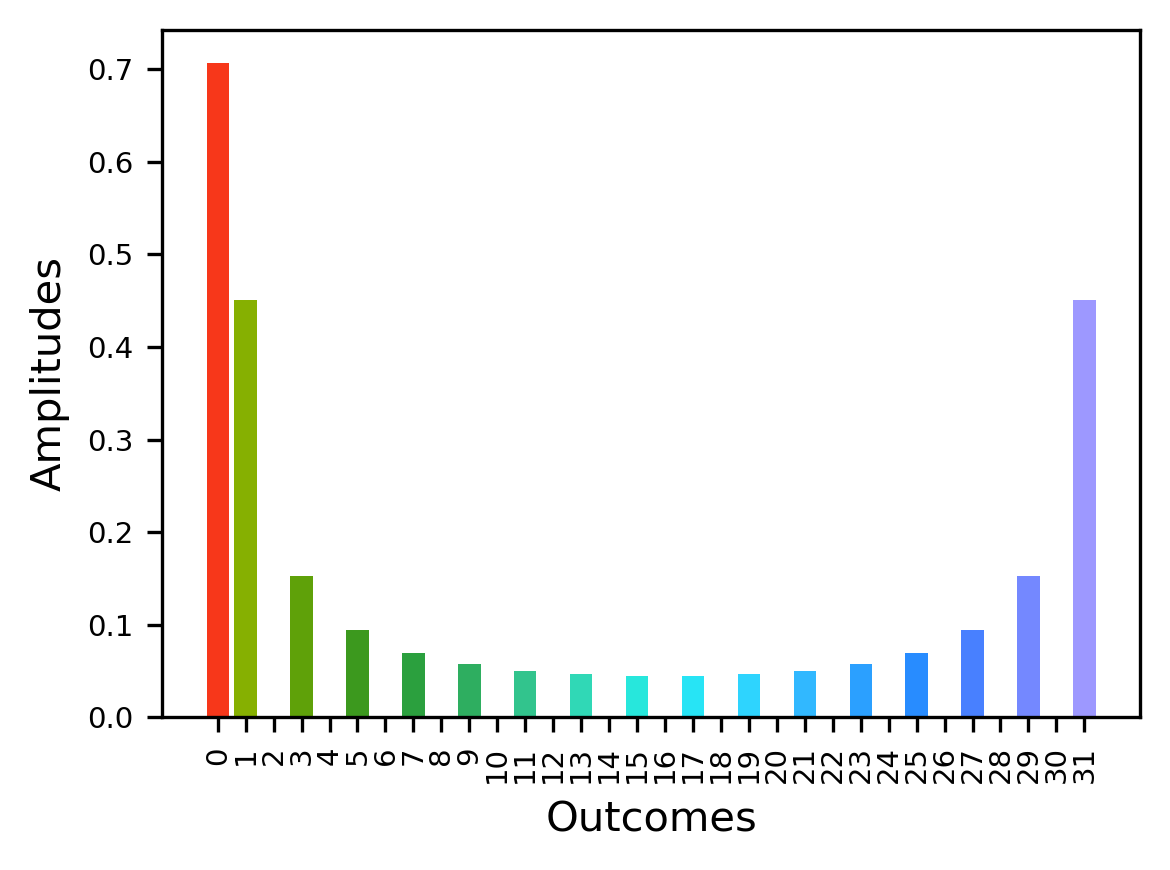

In [21]:
from plot_bars import plot_bars_svg

n = 5
N = 2**n

qc = one_over_sine(n)
state2 = qc.run()
print(len(state2))

plot_bars_svg(list_to_dict(state2, False), '', 'Outcomes', 'Amplitudes')